# Enhanced Interactive Labeling and Model Training Using AI Assistance

This notebook introduces an advanced approach to interactive data labeling, leveraging AI assistance to augment the manual labeling process. The core functionality of this notebook is the continuous refinement of the model through incorporating real-time user feedback. As users engage in labeling their dataset, the model learns from their inputs, enhancing its ability to make more accurate predictions over time. Key functionalities developed in this notebook, using a CSV file and integrated AI APIs, include:

1. Targeted Data Retrieval: Implement a feature to extract a specific number of consecutive lines from a transcript, along with their corresponding labels. This selective retrieval allows for focused and efficient data processing.
 
2. Mislabeled Data Correction and Accuracy Assessment: Introduce a mechanism to identify and correct mislabeled instances in the dataset. This component not only corrects errors but also calculates the accuracy of the model's predictions, providing valuable insights into its performance.

3. Incremental Model Training: Develop a system that utilizes the corrected labels as additional training data. This process enables the model to learn from its mistakes and apply this new knowledge to future predictions, progressively and iteratively improving its accuracy.

4. Dynamic Batch Sizing: Adaptively determines the size of data batches for processing. This method conditions the batch sizes on the accuracy of the model's recent predictions, optimizing the balance between efficiency and the need for user intervention.


This notebook serves as a comprehensive guide to building a sophisticated, AI-assisted labeling workflow that not only aids in the manual labeling process but also evolves the model's capabilities through continuous learning and adaptation. In running this notebook, please read the text between each code block carefully as the notebook is sequential in nature and contains several interactive components that require the code to be executed in the correct order. 

In [ ]:
# Importing necessary libraries 
import os
import getpass
import pandas as pd
from openai import OpenAI
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from ai_assisted_coding_final import assistant # Importing all functions from assistant.py
from ai_assisted_coding_final.interactive_labeling import * # Importing all functions from interactive_labeling.py

**API KEY**

The next block of code will ask you to input your API Key. If you do not have one, please go to [make an account](https://platform.openai.com/docs/quickstart?context=python) and then set up an API key [here](https://platform.openai.com/api-keys). This functionality does cost money so you will need to pay for usage before proceeding.

In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
from openai import OpenAI
client = OpenAI()

## Instantiating Assistant

The code block below will create a Custom Teacher Utterances Classifier Assistant that will leverage Generative AI to aid you in labeling. You have to options:

1. Running the first code block will run your assistant using the GPT-4 Turbo with vision model, which costs costs $0.01/1k prompt tokens
2. Running the second, will run your assistant using GPT-3.5 Turbo, which costs 0.003/1K input 

If you receive an error indicating that 'gpt-4-1106-preview' is not available, please use option 2. 

The assistant only needs to be **instantiated once**. After creating the initial assistant, the assistant ID will be printed. Please save this and run the code below to retrieve your assistant once you restart the kernel or come back to this notebook. This will allow you to use the same assistant, rather than initializing new one every time you to access the functionality in this notebook.

In [4]:
# Creating an instance of the assistant manager
assistant_manager = assistant.OpenAIAssistantManager(client)

The function below processes the input text, sending them to the assistant to generate label predictions for each sentence, returning the original text and the predicted label line by line.


In [14]:
def process_lines_str(lines, assistant_manager, context = ""):
    data = []
    additional_context = "Return a list of labels for each utterance. Each utterance is separated by \n"
    context += additional_context
    assistant_manager.create_thread(context)

    all_lines = "\n ".join(lines)

    completed_run = assistant_manager.submit_message(all_lines)

    response_page = assistant_manager.get_response()
    print(response_page)

    messages = [msg for msg in response_page] 
    print("messages", messages)

    assistant_message = messages[-1].content[0].text.value
    print("assistant_message", assistant_message)

    labels = assistant_message.replace('\n', ' ').replace(',', ' ').split()

    # append tuple (line, label) to data using zip
    data = list(zip(lines, labels))
    print("data", data)
    
    return(data) 

In [18]:
assistant_manager.__dict__

{'client': <openai.OpenAI at 0xffffb8311870>,
 'current_assistant': Assistant(id='asst_pG2tVNaCGT0DcZARLqCPca0b', created_at=1702409312, description='A tool for classifying teacher utterances into the categories OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral).', file_ids=[], instructions="You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That's right, 'he' is a pronoun because it can take the place of a noun.\n                                            assista

Below is an example of how to use the function above to process a list of sentences and return the predicted labels for each sentence. We pass 5 sentences to the function and the assistant returns 5 label predictions. 

In [15]:
predictions = process_lines_str(['Plants are very important because they produce oxygen, which we breathe.', "Let's start with the parts of a plant. Can anyone name a part of a plant?", 'Great, the root is indeed a part of the plant!', 'The main parts of a plant are the root, stem, leaves, and flowers.', "Now, let's talk about photosynthesis."], 
              assistant_manager, 
              context = """Here are more examples of how to classify utterances:
                            user: 'Good morning class, today we are going to learn about plants and photosynthesis.'
                            assistant: 'NEU'
                            I am going to provide several more sentences. Only answer with the following three-letter labels: OTR, PRS, REP, NEU""")
predictions

SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_DUbGmmN6p23Q9G2BF8cq0uJl', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value="Here are more examples of how to classify utterances:\n                            user: 'Good morning class, today we are going to learn about plants and photosynthesis.'\n                            assistant: 'NEU'\n                            I am going to provide several more sentences. Only answer with the following three-letter labels: OTR, PRS, REP, NEUReturn a list of labels for each utterance. Each utterance is separated by \n"), type='text')], created_at=1702410170, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_kv7gn2PWsSDqHTkGORgAxoXz'), ThreadMessage(id='msg_pjeihKsUWKwAQ7JNcr8Kd4CJ', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value="Plants are very important because they produce oxygen, which we breathe.\n Let's start with the parts

[('Plants are very important because they produce oxygen, which we breathe.',
  'NEU'),
 ("Let's start with the parts of a plant. Can anyone name a part of a plant?",
  'OTR'),
 ('Great, the root is indeed a part of the plant!', 'PRS'),
 ('The main parts of a plant are the root, stem, leaves, and flowers.', 'NEU'),
 ("Now, let's talk about photosynthesis.", 'NEU')]

The code below takes in a list of sentences and sends them to the assistant to generate a predicted label for each line based on the given context, returning the sentences paired with the assistants labeled output.

In [10]:
def process_lines(lines, assistant_manager, context = ""):
    data = []
    additional_context = "Return a list of labels for each utterance separated by \n"
    context += additional_context
    assistant_manager.create_thread(context)

    all_lines = "\n ".join(lines)

    completed_run = assistant_manager.submit_message(all_lines)

    response_page = assistant_manager.get_response()

    messages = [msg for msg in response_page] 

    assistant_message = messages[-1].content[0].text.value

    labels = assistant_message.replace('\n', ' ').replace(',', ' ').split()

    # append tupe (line, label) to data using zip
    data = list(zip(lines, labels))
    
    return(data) 

Below is an example of process_lines functionality, showing how process_lines takes in a list of sentences alongside the updated labeling context and sends it to the assistant to generate predicted labels. This demonstrates how the assistant is used to automatically apply labels for a series of sentence samples based on the labeling context.

In [11]:
predictions = process_lines(['Great choice! Those words are indeed synonyms.', 'Next, we are going to learn about antonyms.', 'Antonyms are words that have opposite meanings.', "For example, the words 'big' and 'small' are antonyms.", 'Can someone give me another pair of antonyms?'], 
              assistant_manager, 
              context = """Here are more examples of how to classify utterances:
                            user: 'Good morning class, today we are going to learn about synonyms, antonyms, and homophones.'
                            assistant: 'NEU'
                            user: 'Let's start with synonyms. Synonyms are words that have similar meanings.'
                            assistant: 'NEU'
                            user: 'For example, the words 'happy' and 'joyful' are synonyms.'
                            assistant: 'NEU'
                            user: 'Can anyone give me another pair of synonyms?'
                            assistant: 'OTR'
                            I am going to provide several more sentences. Only answer with the following three-letter labels: OTR, PRS, REP, NEU""")
predictions

[('Great choice! Those words are indeed synonyms.', 'PRS'),
 ('Next, we are going to learn about antonyms.', 'NEU'),
 ('Antonyms are words that have opposite meanings.', 'NEU'),
 ("For example, the words 'big' and 'small' are antonyms.", 'NEU'),
 ('Can someone give me another pair of antonyms?', 'OTR')]

Print the predictions generated from process_lines here. 

In [12]:
for index, (text, prediction) in enumerate(predictions):
    print(f"Prediction {index + 1}: {prediction}")
    print(f"Text: {text}")
    print()


Prediction 1: PRS
Text: Great choice! Those words are indeed synonyms.

Prediction 2: NEU
Text: Next, we are going to learn about antonyms.

Prediction 3: NEU
Text: Antonyms are words that have opposite meanings.

Prediction 4: NEU
Text: For example, the words 'big' and 'small' are antonyms.

Prediction 5: OTR
Text: Can someone give me another pair of antonyms?


**Create an assistant** depending on your preferred model (GPT-4 Turbo or GPT-3.5 Turbo). Please uncomment the line of code that corresponds to the model you want to use.

Exact models: 
**GPT-4**: pt-4-1106-preview assistant
**GPT-3.5**: gpt-3.5-turbo assistant

In [ ]:
# creates assistant using GPT-4
#assistant_manager.create_assistant()

# creates assistant using GPT-3.5
#assistant_manager.create_custom_assistant()

**Retrieve previously created assistant**

If you have already created an assistant and would like to retrieve it, please run the code below and input the assistant ID that was printed when you created the assistant.

In [6]:
assistant_manager.retrieve_assistant("asst_hKIvXCjccLnlUMhZEncw4PPX")

asst_hKIvXCjccLnlUMhZEncw4PPX


## User Inputs 

In [ ]:
FILE_PATH = "data/231-3.csv"  # This is the path to the file you want to label
NUM_MANUAL_LABELS = 5 # This is the number of lines you want to label manually before starting the active learning loop
INITIAL_BATCH_SIZE = 5 # This is the number of examples you want to start with
MAX_LABELS = 500 # This is the maximum number of labels you want to create, only use if you only want to label a subset of the data

## Initializing Data Structures

In [17]:
# Read data
lines = read_csv(FILE_PATH)
end_line = min(MAX_LABELS, len(lines)-1)
initial_data = lines[:NUM_MANUAL_LABELS]  # Adjust as needed
unlabeled_data = lines[NUM_MANUAL_LABELS:]

In [18]:
all_labeled_data = []
context = ""
accuracy_scores = []
batch_sizes = []
batch_size = INITIAL_BATCH_SIZE

## Initial Labeling

The block below will print out 5 labels. You will be asked to input the correct label for each line. The input box will only accept one of the four possible three letter labels: 
* OTR: An opportunity to respond (e.g., 'What color is this candy?')
* PRS: Praise (e.g., "Great job, Morgan!")
* REP: Reprimand (e.g., "You need to keep quiet while someone else is reading.")
* NEU: None of the above

In [19]:
# Display all lines first
for data in initial_data:
    print(f"Line to label: {data}")

Line to label: Good morning class, today we are going to learn about ancient civilizations.
Line to label: Can anyone tell me what a civilization is?
Line to label: Yes, that's right. A civilization is a complex society with its own government, religion, and economy.
Line to label: Now, let's talk about the first civilization we know of, the Sumerians.
Line to label: They lived in a region called Mesopotamia. Can anyone find Mesopotamia on the map?


The labels you just assigned will now be used as context to improve the model classification accuracy on the next batch of data. Specifically, these labels will be sent to our Custom Teacher Utterances Classifier Assistant as context.

In [20]:
# Then collect labels for each line
context = "Here are more examples of how to classify utterances:"
all_labeled_data = []

for data in initial_data:
    label = label_data(data)
    context += f"\nuser: '{data}'\nassistant: '{label}'"
    all_labeled_data.append((data, label))
context += "\nI am going to provide several more sentences. Only answer with one of the following three letter labels: OTR, PRS, REP, NEU"


## In the Loop Labeling

We will begin the active learning loop by processing the first batch of data. The code block below will process the first batch of data, get predictions, allow user input for verification or correction, and calculate batch accuracy. This loop will continue to run until it has processed all the data in the csv file. If you are only interested in labeling a subset of the data please change the 'MAX_LABELS' input at the top of the notebook.

In [24]:
i = 0
while i < len(unlabeled_data):
    batch, actual_batch_size = process_batch(unlabeled_data, i, batch_size, batch_sizes)
    labeled_data, correct_responses = get_user_labels(batch, assistant_manager, context)
    all_labeled_data.extend(labeled_data)

    accuracy = correct_responses / actual_batch_size  # Use actual_batch_size here
    accuracy_scores.append(accuracy)

    batch_size = increase_batch_size(batch_size, accuracy)
    i += actual_batch_size
    print("Progress: {}/{}".format(i, len(unlabeled_data)))

Predicted for 'Good job, Sarah! Mesopotamia is between the Tigris and Euphrates rivers.': PRS
Predicted for 'The Sumerians invented many things we still use today. Can anyone give me an example?': OTR
Predicted for 'Excellent, they did invent the wheel!': PRS
Predicted for 'They also invented writing. They wrote on clay tablets using a script called cuneiform.': NEU
Predicted for 'Jack, please stop talking while I am teaching.': REP
Progress: 5/68
Predicted for 'Let's move on to the ancient Egyptians.': NEU
Predicted for 'They built incredible structures called pyramids. Does anyone know why they built these?': OTR
Predicted for 'That's correct, they built them as tombs for their pharaohs.': PRS
Predicted for 'Can anyone tell me about a famous pharaoh?': OTR
Predicted for 'Yes, King Tutankhamun is a very famous pharaoh.': NEU
Predicted for 'The ancient Egyptians also invented paper using a plant called papyrus.': NEU
Predicted for 'Now, let's talk about the ancient Greeks.': NEU
Predic

## Accuracy and Batch Size Summary

This section will let us evaluate the accuracy of the model over each batch as well as the size of the batch during each run. Run the code below to see the values for each batch, as well as a visualization of these values over time.

In [ ]:
display(accuracy_scores)
display(batch_sizes)

In [ ]:
# Plot 1: Accuracy Scores Across Batches
plt.plot(accuracy_scores, 'o-')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.xticks(range(len(accuracy_scores)))
plt.title('Prediction Accuracy Per Batch')
plt.show()

# Plot 2: Batch Size Across Batches (over time)
plt.plot(batch_sizes)
plt.ylabel('Batch Size')
plt.xlabel('Batch Number')
plt.xticks(range(len(batch_sizes)))
plt.title('Batch Size Across Batches')
plt.show()

In [29]:
batch_sizes

[5, 10, 5, 10, 10, 10, 10, 8]

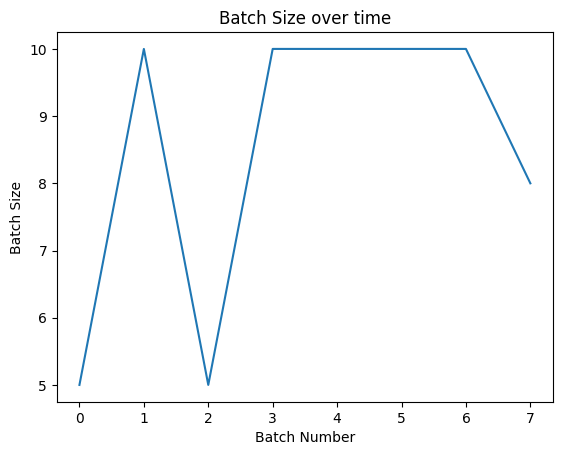

In [30]:
# Plot Batch Size against Batch Number
plt.plot(batch_sizes)
plt.ylabel('Batch Size')
plt.xlabel('Batch Number')
plt.xticks(range(len(batch_sizes)))
plt.title('Batch Size over time')
plt.show()

## Label Summary Statistics


Run the code below to see the distribution of labels in the final dataset.

In [31]:
labeled_df = pd.DataFrame(all_labeled_data, columns=["Text", "Label"])
labeled_df["Label"].value_counts()

Label
NEU    44
OTR    19
PRS     5
REP     5
Name: count, dtype: int64

## Save labeled data as csv file

Run the code below to save the labeled data as a csv file. If you would like to label another CSV file, please return to the top of the notebook and specify the new file path containing the new CSV. You may also change the number of manual labels you would like to start with, the initial batch size, and the maximum number of labels to create for further customization.

In [32]:
labeled_df.to_csv("test_labeled_data.csv", index=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Appendix: Step by Step Workflow To Understand How it Works 

In [14]:
# Read data
lines = read_csv('data/009-1.csv')

In [17]:
# Create a thread to 'host' the conversation
assistant_manager.create_thread("")

Thread(id='thread_EP2OnI2OjhOgK0hNkRSzlBmv', created_at=1702257975, metadata={}, object='thread')

In [18]:
assistant_manager.submit_message(lines[0]) # Submit the first message to the assistant
response_page = assistant_manager.get_response() # Get the response from the assistant
messages = [msg for msg in response_page] # Get the messages from the response page
assistant_message = messages[-1].content[0].text.value # Get the assistant's message
label = assistant_message.split()[-1] # Get the label from the assistant's message

Run(id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', cancelled_at=None, completed_at=1702257978, created_at=1702257977, expires_at=None, failed_at=None, file_ids=[], instructions='You are the co-founder of an ed-tech startup training an automated teacher feedback tool to classify utterances made. I am going to provide several sentences. \n                                            Please classify each sentence as one of the following: OTR (opportunity to respond), PRS (praise), REP (reprimand), or NEU (neutral)\n        \n                                            user: Can someone give me an example of a pronoun?\n                                            assistant: OTR\n                                            user: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\n                                            assistant: PRS\n                                            user: "You need to keep quiet while someone else is 

In [22]:
# this is the first message that the assistant sends
messages 

[ThreadMessage(id='msg_UOBcifBcBqUNC09AnRkmZwFX', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=''), type='text')], created_at=1702257975, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_juR6FX501z4WJsMpoYKICF6Q', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Good morning class, today we are going to learn about nouns.'), type='text')], created_at=1702257977, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_EP2OnI2OjhOgK0hNkRSzlBmv'),
 ThreadMessage(id='msg_zm20h3opeV17gdNH5RZ79Piv', assistant_id='asst_5PmNo4HYGKLTVlTUgzbte0IK', content=[MessageContentText(text=Text(annotations=[], value='NEU'), type='text')], created_at=1702257978, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_J9mn5gwg3Gu5Fqk4AtlR0JvZ', thread_id='thread_EP2OnI2OjhOgK0hNkRSzlB

In [23]:
# this is text of the first message that the assistant sends
messages[-1].content[0].text.value

'NEU'

In [ ]:
# this is how we get the label from the assistant's message
label = assistant_message.split()[-1]

In [29]:
# this is the core function called within get_user_labels inside the loop
process_lines(lines[0:5], assistant_manager)

[('Good morning class, today we are going to learn about nouns.', 'NEU'),
 ('A noun is a word that represents a person, place, thing, or idea.', 'NEU'),
 ('Can anyone give me an example of a noun?', 'NEU'),
 ("That's right, 'dog' is a noun because it is a thing.", 'NEU'),
 ("Let's write down some nouns in our notebooks.", 'NEU')]

In [14]:
# This is an example of using the correvtly labeled data to train a model and create a new thread with this expanded context to classify the next batch 
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances::

user: Good morning class, today we are going to learn about nouns.
assistant: NEU
user: A noun is a word that represents a person, place, thing, or idea.
assistant: NEU
user: "Can anyone give me an example of a noun?"
assistant: OTR
user: That's right, 'dog' is a noun because it is a thing.
assistant: PRS

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )


In [15]:
# Wait for the response and get it
response_page_2 = assistant_manager.get_response()

# Collect all messages from the response page
messages2 = [msg for msg in response_page_2]

In [16]:
assistant_message_2 = messages2[-1].content[0].text.value

In [17]:
assistant_message_2

'Understood, go ahead and provide the sentences.'

In [18]:
messages_3 = process_lines(lines[5:10], assistant_manager)

In [19]:
messages_3

[("Now, let's talk about verbs. Does anyone know what a verb is?", 'OTR'),
 ('A verb is a word that describes an action, occurrence, or state of being.',
  'NEU'),
 ('Can someone give me an example of a verb?', 'OTR'),
 ("Great example, 'run' is a verb because it is an action.", 'PRS'),
 ("Now, let's write down some verbs in our notebooks.", 'OTR')]

In [20]:
df3 = pd.DataFrame(messages_3, columns=["Text", "Label"])

In [21]:
df3

,Text,Label
0,"Now, let's talk about verbs. Does anyone know ...",OTR
1,"A verb is a word that describes an action, occ...",NEU
2,Can someone give me an example of a verb?,OTR
3,"Great example, 'run' is a verb because it is a...",PRS
4,"Now, let's write down some verbs in our notebo...",OTR


In [22]:
thread, completed_run = assistant_manager.create_thread_and_run(""" 
Great. Here are some more examples of how to classify utterances:

user: Can someone give me an example of a pronoun?
assistant: OTR
user: That's right, 'he' is a pronoun because it can take the place of a noun.
assistant: PRS
user: "You need to keep quiet while someone else is reading."
assistant: REP
user: A pronoun is a word that can take the place of a noun.
assistant: NEU
user: I don't appreciate the talking while I am teaching; please show some respect.
assistant: REP
user: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..
assistant: PRS
user: "Before we end, does anyone have any questions?"
assistant: OTR
user: Next class, we will discuss our observations from the experiment.
assistant: NEU

I am going to provide several more sentences. Only answer with the following three latter labels labels: OTR, PRS, REP, NEU
""" )

In [23]:
response_page_4 = assistant_manager.get_response()

# Collect all messages from the response page
messages4 = [msg for msg in response_page_4]

In [24]:
messages4

[ThreadMessage(id='msg_jvPaVvNZN4CKkPUgkKbM7sRk', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value=' \nGreat. Here are some more examples of how to classify utterances:\n\nuser: Can someone give me an example of a pronoun?\nassistant: OTR\nuser: That\'s right, \'he\' is a pronoun because it can take the place of a noun.\nassistant: PRS\nuser: "You need to keep quiet while someone else is reading."\nassistant: REP\nuser: A pronoun is a word that can take the place of a noun.\nassistant: NEU\nuser: I don\'t appreciate the talking while I am teaching; please show some respect.\nassistant: REP\nuser: Good answer, cactus plants have adapted to survive in arid environments by storing water in their stems..\nassistant: PRS\nuser: "Before we end, does anyone have any questions?"\nassistant: OTR\nuser: Next class, we will discuss our observations from the experiment.\nassistant: NEU\n\nI am going to provide several more sentences. Only answer with the following thr

In [25]:
messages_5 = process_lines(lines[11:20], assistant_manager)

In [26]:
messages_5

[('An adjective is a word that describes a noun.', 'NEU'),
 ('Can someone give me an example of an adjective?', 'OTR'),
 ("Exactly, 'beautiful' is an adjective because it describes a noun.", 'PRS'),
 ("Let's write down some adjectives in our notebooks.", 'OTR'),
 ('Now we are going to form sentences using nouns, verbs, and adjectives.',
  'OTR'),
 ('A sentence is a group of words that expresses a complete thought.', 'NEU'),
 ("Let's build a sentence together. I'll start with a noun: 'The cat'.",
  'OTR'),
 ('Can someone add a verb to our sentence?', 'OTR'),
 ("Great, now our sentence is: 'The cat runs'.", 'NEU')]

In [27]:
df5 = pd.DataFrame(messages_5, columns=["Text", "Label"])

In [28]:
df5

,Text,Label
0,An adjective is a word that describes a noun.,NEU
1,Can someone give me an example of an adjective?,OTR
2,"Exactly, 'beautiful' is an adjective because i...",PRS
3,Let's write down some adjectives in our notebo...,OTR
4,Now we are going to form sentences using nouns...,OTR
5,A sentence is a group of words that expresses ...,NEU
6,Let's build a sentence together. I'll start wi...,OTR
7,Can someone add a verb to our sentence?,OTR
8,"Great, now our sentence is: 'The cat runs'.",NEU
